# EDA a partir de la API de MELI
### Parte II: algoritmo predictivo
<a id="top"></a>
Autor: Mathiews Flores Zavala

<p> En esta notebook, voy a explorar los resultados de las publicaciones de MELI meduante su API de acceso público, que se vio en la Parte I (ver en el<a href = 'https://github.com/Mattzvl/EDA_API_ML'> EDA_API_MELI </a> para mas detalles).</p>
<p><strong>Objetivo:</strong> Implementar un algoritmo predictivo para poder predecir las unidades vendidas <i>sold_quantity</i></p>

## Tabla de Contenidos
1. <a href="#1">Data Wrangling</a>
* 1.1 <a href="#1.1">Importando librerías y datos</a>
* 1.2 <a href="#1.2">Exploramos el Data Set </a>
* 1.3 <a href="#1.3">Limpieza del data set: columnas, duplicados y valores NaN</a>
* 1.4 <a href="#1.4">Outliers</a>
* 1.5 <a href="#1.5">Visualización</a>
* 1.6 <a href="#1.6">Feature Engineering</a>
* 1.7 <a href="#1.6">Feature Selection</a>

2. <a href="#2">Preproceso de datos</a>
* 2.1 <a href='#2.1'>Preparacion de los datos</a>
* 2.2 <a href='#2.2'>Separación de datos en Train y Test</a>
* 2.3 <a href='#2.3'> Vectorizamos con Tf_idf</a>
* 2.4 <a href='#2.4'>Encoding de variables categóricas</a>
* 2.5 <a href='#2.5'>Standarización de variables numéricas</a>
* 2.6 <a href='#2.6'>Features de Train y Test</a>

3. <a href="#3">Modelos de Predicción</a>
* 3.1 <a href='#3.1'>Stats Model</a>
    * 3.1.1 <a href='#3.1.1'>Regresión Lineal</a> 
    * 3.1.2 <a href='#3.1.2'>Regresión Lineal con Feature Selection</a> 
    * 3.1.3 <a href='#3.1.3'>VIF</a> 
    * 3.1.4 <a href='#3.1.4'>RFE</a> 
* 3.2 <a href='#3.2'>CatBoost</a>

4. <a href="#4">Conclusiones</a>



---
<a href="#top">Back to Index</a>
<a id="1"></a>
### 1) Data Wrangling
<a id="1.1"></a>
#### 1.1) Importando librerias y datos

In [281]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from time import time, sleep
import re

import warnings
warnings.filterwarnings('ignore')
from bs4 import BeautifulSoup
import unidecode
from nltk.corpus import stopwords 


# Librerias de Machine Learning
from sklearn import preprocessing, metrics, linear_model
from sklearn.metrics import accuracy_score,confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV

from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor

Consulto la API de Mercado Libre publica mediante búsquedas. En esta instacia me focalizaré en recopilar datos para componer una muestra de la población de publicaciones disponibles de la API de MELI

In [3]:
data = pd.read_csv('./data/data_part1.csv')
data.head()

,id,site_id,title,price,prices,sale_price,currency_id,available_quantity,sold_quantity,buying_mode,...,neutral,claims,delayed_handling_time,sales,cancellations,free_shipping,mode,tags.2,logistic_type,store_pick_up
0,MLA898264823,MLA,Smart Tv Tcl 50p8m Led 4k 50,54999.0,"{'id': 'MLA898264823', 'prices': [{'id': '16',...",NaN,ARS,1,121,buy_it_now,...,0.02,"{'rate': 0.0148, 'value': 185, 'period': '60 d...","{'rate': 0.0152, 'value': 181, 'period': '60 d...","{'period': '60 days', 'completed': 11792}","{'rate': 0.003, 'value': 38, 'period': '60 days'}",True,me2,"['mandatory_free_shipping', 'self_service_in']",cross_docking,False
1,MLA905996538,MLA,Smart Tv Hyundai 50 4k Uhd Google Android,49999.0,"{'id': 'MLA905996538', 'prices': [{'id': '139'...",NaN,ARS,1,250,buy_it_now,...,0.01,"{'rate': 0.0084, 'value': 1109, 'period': '60 ...","{'rate': 0, 'value': 0, 'period': '60 days'}","{'period': '60 days', 'completed': 125242}","{'rate': 0, 'value': 0, 'period': '60 days'}",True,me2,"['fulfillment', 'mandatory_free_shipping']",fulfillment,False
2,MLA898844422,MLA,Smart Tv Samsung Series 7 Un50tu7000gczb Led 4...,75999.0,"{'id': 'MLA898844422', 'prices': [{'id': '152'...",NaN,ARS,273,7388,buy_it_now,...,0.01,"{'rate': 0.0084, 'value': 1109, 'period': '60 ...","{'rate': 0, 'value': 0, 'period': '60 days'}","{'period': '60 days', 'completed': 125242}","{'rate': 0, 'value': 0, 'period': '60 days'}",True,me2,"['fulfillment', 'mandatory_free_shipping']",fulfillment,False
3,MLA933497704,MLA,Amazon Fire Tv Stick 4k De Voz 4k 8gb Negro...,10888.0,"{'id': 'MLA933497704', 'prices': [{'id': '1', ...",NaN,ARS,3,2,buy_it_now,...,0.01,"{'rate': 0, 'value': 1, 'period': '60 days'}","{'rate': 0, 'value': 0, 'period': '60 days'}","{'period': '60 days', 'completed': 2364}","{'rate': 0, 'value': 0, 'period': '60 days'}",True,me2,"['self_service_in', 'mandatory_free_shipping']",cross_docking,False
4,MLA926081002,MLA,Smart Tv Bgh 50 Uhd Android,66999.0,"{'id': 'MLA926081002', 'prices': [{'id': '37',...",NaN,ARS,250,250,buy_it_now,...,0.01,"{'rate': 0.0084, 'value': 1109, 'period': '60 ...","{'rate': 0, 'value': 0, 'period': '60 days'}","{'period': '60 days', 'completed': 125242}","{'rate': 0, 'value': 0, 'period': '60 days'}",True,me2,"['fulfillment', 'mandatory_free_shipping']",fulfillment,False


In [4]:
data.shape

(4160, 63)

La busqueda mediante la API de MELI se obtuvo un data set con 4160 registros focalizado principalmente elementos de eletronica como lo son televisores, telefonos, notebooks, tablets.

<a id="1.2"></a>
#### 1.2) Explorando el data set

In [5]:
# explioramos el data set de la parte 1
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4160 entries, 0 to 4159
Data columns (total 63 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4160 non-null   object 
 1   site_id                4160 non-null   object 
 2   title                  4160 non-null   object 
 3   price                  4160 non-null   float64
 4   prices                 4160 non-null   object 
 5   sale_price             0 non-null      float64
 6   currency_id            4160 non-null   object 
 7   available_quantity     4160 non-null   int64  
 8   sold_quantity          4160 non-null   int64  
 9   buying_mode            4160 non-null   object 
 10  listing_type_id        4160 non-null   object 
 11  stop_time              4160 non-null   object 
 12  condition              4160 non-null   object 
 13  permalink              4160 non-null   object 
 14  thumbnail              4160 non-null   object 
 15  thum

In [6]:
# veamos los valores númericos para conocer su comportamiento
data.describe()

,price,sale_price,available_quantity,sold_quantity,original_price,official_store_id,order_backend,id.1,total,canceled,completed,negative,positive,neutral
count,4.160000e+03,0.0,4160.000000,4160.000000,709.000000,621.000000,4160.000000,4.160000e+03,4160.000000,4160.000000,4160.000000,4160.000000,4160.000000,4160.000000
mean,7.448659e+04,NaN,156.363702,50.757212,75526.043554,1090.275362,25.497356,2.081767e+08,51226.624038,2776.597356,48450.026683,0.027495,0.947060,0.023281
std,3.707253e+05,NaN,1515.758183,343.723400,64331.915747,827.029270,14.431171,1.686220e+08,110814.910854,5546.391381,105340.620247,0.042096,0.098846,0.079299
min,3.300000e+01,NaN,1.000000,0.000000,1600.000000,47.000000,1.000000,1.048590e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.500000e+04,NaN,1.000000,1.000000,20899.000000,229.000000,13.000000,8.252185e+07,3235.000000,180.000000,3081.000000,0.010000,0.940000,0.010000
50%,4.995850e+04,NaN,1.000000,5.000000,59999.000000,1205.000000,25.500000,1.727533e+08,13374.000000,958.000000,12740.000000,0.020000,0.960000,0.020000
75%,9.310338e+04,NaN,3.000000,25.000000,109999.000000,1938.000000,38.000000,2.848246e+08,41854.000000,2303.000000,39757.000000,0.030000,0.980000,0.020000
max,2.335000e+07,NaN,50000.000000,10459.000000,395999.000000,2588.000000,50.000000,8.006795e+08,613410.000000,29023.000000,585075.000000,1.000000,1.000000,1.000000


En esta priemra instancia podemos observar que cirtos valores como *id.1, official_store_id, order_backend* no aportaran peso al modelo.
Por otro lado la columna *sale_price* se encuentra vacia.

 <a id="1.3"></a>
#### 1.3) Limpieza del data set: columnas, duplicados y valores NaN
En esta instancia se tratarán las columnas, valores duplicados y nulos.
Además, determinar que registros se conservarán (feature selection)

In [7]:
# eliminamos las columnas que consideramos no nos aportarán al modelo
data_clean = data.drop(['id.1', 'official_store_id', 'order_backend'],axis =1)

In [8]:
# conozco las columnas que posee y para referencia
columnas_ref =data_clean.columns

# exploro cuales son aquellas columnas que contienen id en su nombre y que pueden ser simplemente primaries o foreign keys
indices_col_ref = [pos for pos, element in enumerate(columnas_ref) if 'id' in element]
columnas_ref[indices_col_ref]

Index(['id', 'site_id', 'currency_id', 'listing_type_id', 'thumbnail_id',
       'category_id', 'domain_id', 'catalog_product_id', 'use_thumbnail_id',
       'state_id', 'city_id', 'level_id'],
      dtype='object')

In [9]:
# veamos el data set que contiene solamente columnas con la palabra id
data_clean[columnas_ref[indices_col_ref]]

,id,site_id,currency_id,listing_type_id,thumbnail_id,category_id,domain_id,catalog_product_id,use_thumbnail_id,state_id,city_id,level_id
0,MLA898264823,MLA,ARS,gold_special,849404-MLA45797322642_052021,MLA1002,MLA-TELEVISIONS,MLA15186500,True,AR-C,NaN,5_green
1,MLA905996538,MLA,ARS,gold_special,836204-MLA44728420590_012021,MLA1002,MLA-TELEVISIONS,MLA17849007,True,AR-B,NaN,5_green
2,MLA898844422,MLA,ARS,gold_pro,878604-MLA44160072739_112020,MLA1002,MLA-TELEVISIONS,MLA16233171,True,AR-B,NaN,5_green
3,MLA933497704,MLA,ARS,gold_special,700522-MLA46539887496_062021,MLA352001,MLA-STREAMING_MEDIA_DEVICES,MLA14141341,True,AR-C,NaN,5_green
4,MLA926081002,MLA,ARS,gold_pro,893006-MLA46430431526_062021,MLA1002,MLA-TELEVISIONS,NaN,True,AR-B,NaN,5_green
...,...,...,...,...,...,...,...,...,...,...,...,...
4155,MLA871820328,MLA,ARS,gold_pro,718399-MLA41642098919_052020,MLA1652,MLA-NOTEBOOKS,NaN,False,AR-C,TUxBQlZJTDQyMjBa,5_green
4156,MLA900496858,MLA,ARS,gold_pro,871478-MLA42424954747_062020,MLA1652,MLA-NOTEBOOKS,NaN,False,AR-C,TUxBQkJFTDcyNTJa,5_green
4157,MLA895870357,MLA,ARS,gold_pro,612018-MLA46887309472_072021,MLA1652,MLA-NOTEBOOKS,MLA17328361,False,AR-B,NaN,5_green
4158,MLA866181995,MLA,ARS,gold_special,698116-MLA46101176637_052021,MLA1652,MLA-NOTEBOOKS,MLA16053932,False,AR-C,TUxBQlNBTjgzMjRa,5_green


In [10]:
def cant_valores_unicos(df):
    '''Cuenta la cantidad de valores unicos que existen cada columna de un dataset y devuelve un diccionario'''
    columnas = df.columns
    rta = {}
    for col in columnas:
        rta[col] = len(df[col].value_counts())
    return rta

In [11]:
cant_valores_unicos( data_clean[columnas_ref[indices_col_ref]] )

{'id': 4152,
 'site_id': 1,
 'currency_id': 1,
 'listing_type_id': 2,
 'thumbnail_id': 3437,
 'category_id': 14,
 'domain_id': 11,
 'catalog_product_id': 1221,
 'use_thumbnail_id': 2,
 'state_id': 19,
 'city_id': 98,
 'level_id': 4}

Como se puede observar, solo hay valores únicos para *site_id, currency_id* por lo tanto dropeare estos ya que no aportaran sustancialmente algo al modelo. Esto tiene sentido ya que los valores de las busquedas a la API se realizaron mediante el sitio MLA, por consiguiente la moneda predominante debería ser PESOS ARS.

In [12]:
data_clean = data_clean.drop(['site_id', 'currency_id'],axis =1)

Ocurre algo similar con *state_id, city_id* donde al ya tener *state_name, y city_name* estas resultan redundantes para el análisis. Así que tambien serán dropeadas.

In [13]:
data_clean = data_clean.drop(['state_id', 'city_id'],axis =1)

Tratamiento de valores duplicados, existen valores duplicados? es decir que contengan exactamente la misma data en sus registros.

In [14]:
# tratamiento de duplicados
print('Hay {} registros duplicados'.format(data_clean.duplicated().sum() ))

# eliminamos los registros duplicados
data_clean.drop_duplicates(inplace = True, keep='last')

print('\nQuedan registros duplicados?', data.duplicated().any() )

Hay 8 registros duplicados

Quedan registros duplicados? False


Respecto de datos *id* de las publicaciones que actuarian como una llave para los registros. En este caso, la cantidad de registros únicos coincidecon la cantidad de registros duplicados.
Por otro lado, respecto de las miñiaturas *thumbnail_id, use_thumbnail_id* no serán incorporadas al modelo.

In [15]:
data_clean = data_clean.drop(['thumbnail_id', 'use_thumbnail_id'],axis =1)

La columna *category_id* esta estreñamente relacionada con *domain_id* por lo tanto mantendremos solamente *domain_id*, que se utilizó en una instancia anterior para poder analizar los datos por categorias.

In [16]:
data_clean = data_clean.drop(['category_id'],axis =1)

In [17]:
# volvamos a ver cuantas son las que columnas que conservamos
columnas_ref2 =data_clean.columns
indices_col_ref2 = [pos for pos, element in enumerate(columnas_ref2) if 'id' in element]
columnas_ref2[indices_col_ref2]

Index(['id', 'listing_type_id', 'domain_id', 'catalog_product_id', 'level_id'], dtype='object')

In [18]:
# level_id parece indicar, siendo redundante, el nivel donde verde es muy bueno y naranja no tan bueno, esto relacionado
# con la confiabilidad/reputacion del vendedor que se indica en el portal de mercado libre usando esta escala.
data_clean['level_id'].value_counts()

5_green          3996
3_yellow           48
2_orange           13
4_light_green       8
Name: level_id, dtype: int64

In [19]:
# veamos que pasa con listing_type, el tipo de cotizacion se puede ver que hay dos tipos de categoria
data_clean['listing_type_id'].value_counts()

gold_special    2823
gold_pro        1329
Name: listing_type_id, dtype: int64

Para esta instancia es claro denotar que hay información que puede ser redundante y a su vez equivalente a otras, la descripción de una publicación se conrresponde con el id, pero ofrece data que puede ser más sustancial.

Por otro lado, *catalog_product_id* es el producto que se publica, que puede ser común para varias publicaciones (estan correlacionadas)

In [20]:
data_clean = data_clean.drop(['id'],axis =1)

Concentremonos en los **valores nulos** que tenemos, como se vio anteriormente *sale_price* es la única columna con todos sus registros nulos.

In [56]:
data_clean = data_clean.drop(['sale_price'],axis =1)

KeyError: "['sale_price'] not found in axis"

<a id="1.4"></a>
#### 1.4) Eliminación de Outliers

En esta instancia se eliminaran ciertos outliers que pueden hacer ruido en el modelo, principalmente aquellos vistos en la Parte I (ver en el<a href = 'https://github.com/Mattzvl/EDA_API_ML'> EDA_API_MELI </a> para mas detalles).</p> En este caso se empezará por el precio

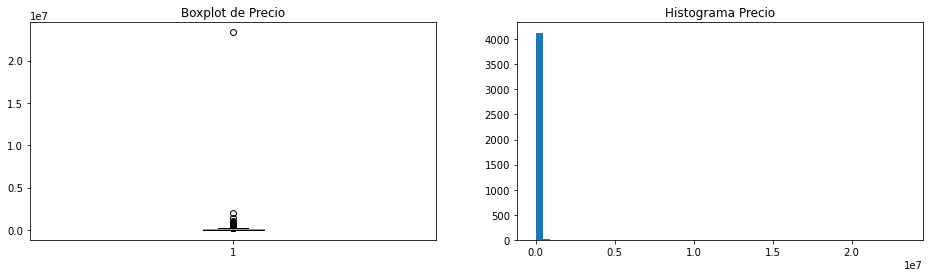

In [57]:
plt.figure(figsize = (16, 4))
ax = plt.subplot(1,2,1)
plt.boxplot(data=data_clean, x='price')
plt.title('Boxplot de Precio');

ax = plt.subplot(1,2,2)
plt.hist(data=data_clean, x='price', bins=50)
plt.title('Histograma Precio');

La forma del histograma hace recordar a los vistos en la parte 1, en particular para Tables y Televisores

In [58]:
# quitamos las  filas con distancias mayores a 1.5 + IQR
Q1_d, Q3_d = np.percentile(data_clean['price'], [25, 75])
IQR_d = Q3_d-Q1_d
lower_bound_d = Q1_d - (1.5 * IQR_d)
upper_bound_d = Q3_d + (1.5 * IQR_d)
# outlier_index = np.where((x < lower_bound) | (x > upper_bound))

# nos quedamos con las aquellos precios originales menores al quartil 3
data_clean2 = data_clean.loc[data_clean['price'] < upper_bound_d]

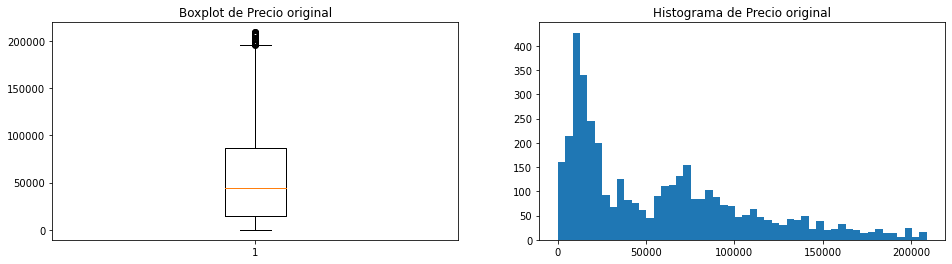

In [59]:
# veamos como resulto leugo de la eliminación de outlies
plt.figure(figsize = (16, 4))
ax = plt.subplot(1,2,1)
plt.boxplot(data=data_clean2, x='price')
plt.title('Boxplot de Precio original');

ax = plt.subplot(1,2,2)
plt.hist(data=data_clean2, x='price', bins=50)
plt.title('Histograma de Precio original');

Luego de la eliminación de Outliers se puede apreciar una distribución normal segada por la derecha, si bien siguen quedando algunos valores que estan algo por encima fuera del boxplot, los conservaremos apra el modelo.

<a id="1.5"></a>
#### 1.5) Visualizacion de datos

In [60]:
(data_clean2.groupby('domain_id')['original_price'].agg(['mean','median','std','max','min']).round(2)).sort_values(by = 'mean', ascending=False)

,mean,median,std,max,min
domain_id,,,,,
MLA-NOTEBOOKS,122142.01,115615.00,50866.68,264999.00,40137.00
MLA-TELEVISIONS,101763.52,87549.00,38669.40,225499.00,59999.00
MLA-CELLPHONES,31816.89,25644.50,26016.49,208999.00,4839.00
MLA-TABLETS,22917.85,18999.00,16502.70,145000.00,7999.00
MLA-STREAMING_MEDIA_DEVICES,11409.45,10749.00,4200.62,20000.00,7019.00
MLA-TV_RECEIVERS_AND_DECODERS,9999.00,9999.00,NaN,9999.00,9999.00
MLA-TV_AND_MONITOR_MOUNTS,6999.99,6999.99,NaN,6999.99,6999.99
MLA-AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS,2818.00,2818.00,359.21,3072.00,2564.00
MLA-TV_REMOTE_CONTROL_COVERS,1600.00,1600.00,NaN,1600.00,1600.00


Las notebooks representan aquellos productos que tienen el mayor precio promedio (independientemente de la gama del articulo)
En tanto que las tablets tienen el menor precio medio.

Los valores máx quedaron mucho más coherentes, aunque hay casos donde el min de television, telefonos y tablet que son casi 2500 veces menores a la media, del orden de 1e-4.

Aquellos que tienen std = NaN, son aquellos elementos que son unicos, ya que temino dividinedo por 0 (n-1).
Estos son productos que se colaron el la busqueda de television, donde los resultados entregados no fueron tan precisos como con tablets, notebooks y celulares.

domain_id = ['MLA-ELECTRONIC_ACCESSORIES_AND_SPARE_PARTS', 'MLA-TV_RECEIVERS_AND_DECODERS', 'MLA-TV_REMOTE_CONTROL_COVERS']

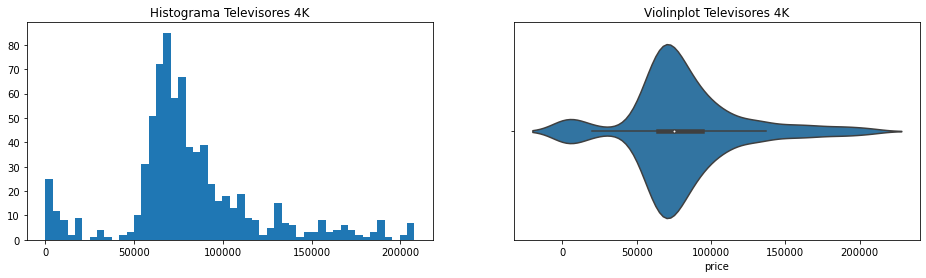

In [61]:
plt.figure(figsize = (16, 4))

ax = plt.subplot(1,2,1)
data_2plot = data_clean2[data_clean2['domain_id'] == 'MLA-TELEVISIONS']
plt.hist(data=data_2plot, x='price', bins=50)
plt.title('Histograma Televisores 4K')

ax = plt.subplot(1,2,2)
sns.violinplot(data=data_2plot, x='price', bins=10)
plt.title('Violinplot Televisores 4K')
plt.show()

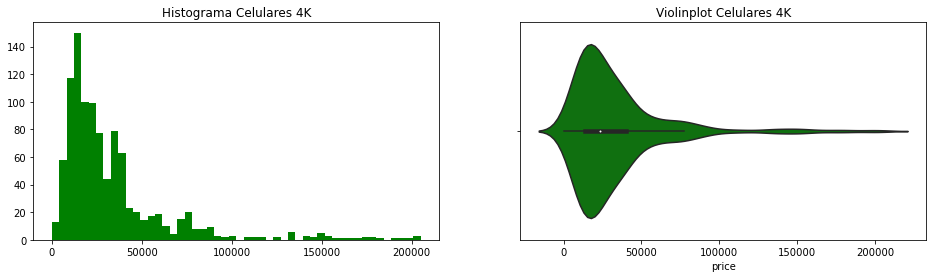

In [62]:
plt.figure(figsize = (16, 4))
ax = plt.subplot(1,2,1)
data_2plot = data_clean2[data_clean2['domain_id'] == 'MLA-CELLPHONES']
plt.hist(data=data_2plot, x='price', bins=50, color= 'green')
plt.title('Histograma Celulares 4K')

ax = plt.subplot(1,2,2)
sns.violinplot(data=data_2plot, x='price', bins=10, color= 'green')
plt.title('Violinplot Celulares 4K')
plt.show()

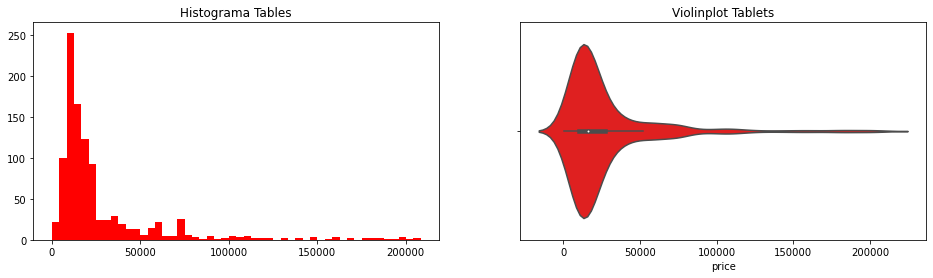

In [63]:
plt.figure(figsize = (16, 4))
ax = plt.subplot(1,2,1)
data_2plot = data_clean2[data_clean2['domain_id'] == 'MLA-TABLETS']
plt.hist(data=data_2plot, x='price', bins=50, color= 'red')
plt.title('Histograma Tables')

ax = plt.subplot(1,2,2)
sns.violinplot(data=data_2plot, x='price', bins=50, color= 'red')
plt.title('Violinplot Tablets')
plt.show()

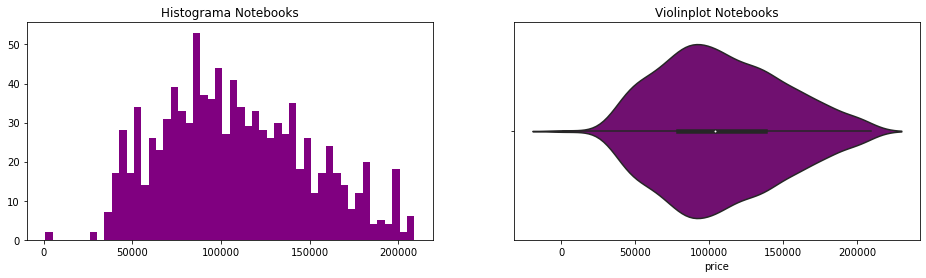

In [64]:
plt.figure(figsize = (16, 4))
ax = plt.subplot(1,2,1)
data_2plot = data_clean2[data_clean2['domain_id'] == 'MLA-NOTEBOOKS']
plt.hist(data=data_2plot, x='price', bins=50, color= 'purple')
plt.title('Histograma Notebooks')

ax = plt.subplot(1,2,2)
sns.violinplot(data=data_2plot, x='price', bins=50, color= 'purple')
plt.title('Violinplot Notebooks')
plt.show()

Los histogramas parecen distribuciones normales, la mayoria segadas hacia la izquierda (precios más bajos) al menos en televisores, celulares y tablets.

Se observa que hay ciertos datos anómalos al menos en la zona televisores que forman otro pico en uno de los extremos de la distribución, esto podría deberse a productos que tengan relación estrecha con televiosres, como controles, accesorios, sin embargo recibieron se etiquetaron con el *domain_id* que le corresponde a los televisores.

#### Estudio de correlaciones

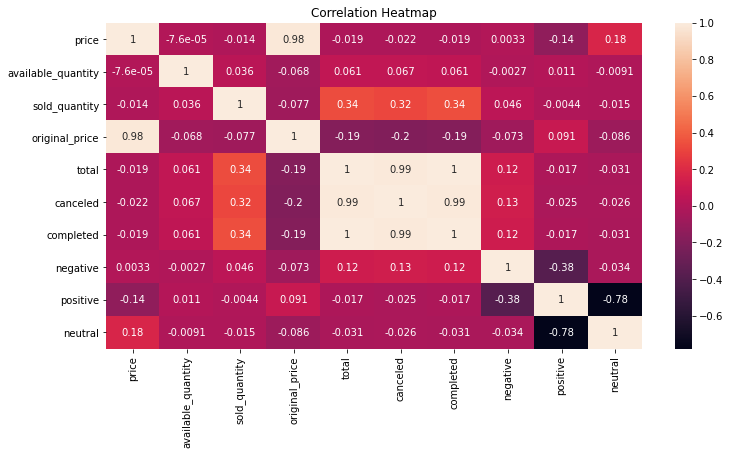

In [65]:
# graficamos un heatmap para exploras la relacion entre variables
plt.figure(figsize=(12,6))
# para no incorporar solamente aquellas variables numericas, ya que de lo contrario me tomaria los buleanos 
num_cols = [x for x in data_clean2.select_dtypes(include=['number']).columns]
sns.heatmap(data_clean[num_cols].corr(),annot=True)
plt.title("Correlation Heatmap")
plt.show()

De lo observado en el heat map, se puede ver que *sold_quantity* tiene relación poca correlación varios campos, la relación negativa de unidades vendidas con el precio, nos indicaría a priori que a mayor precio menos unidades vendidas.

Los aportes de cantidad de pedidos *total, canceled, completes* tienen practicamente el mismo aporte. Luego el rate *negative, positive, neutral* tienen un aporte cercano al cero. Lo mismo con *aviable_quantity*.

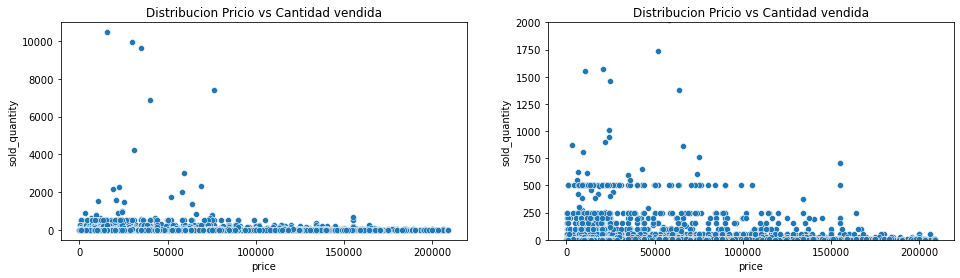

In [66]:
#Correlación entre cantidades vendidas y el precio
plt.figure(figsize = (16, 4))
data2plot1 = data_clean2.loc[:,['sold_quantity','price',]].copy()
ax = plt.subplot(1,2,1)
sns.scatterplot(data= data2plot1 ,x='price',y='sold_quantity')
plt.title('Distribucion Pricio vs Cantidad vendida');

ax = plt.subplot(1,2,2)
sns.scatterplot(data= data2plot1 ,x='price',y='sold_quantity')
plt.ylim(0, 2000)
plt.title('Distribucion Pricio vs Cantidad vendida');

<a id="1.6"></a>
#### 1.6) Feature Engineering

Respecto de los valores **nulos** de la columna *original_price*, aquellos registros con valores *nulls* corresponden a valores donde se aplica un descuento. Al ser *original_price* correlativa a *price*, voy a conservar price, sin embargo se generará un nuevo campo que represente el % de descuento.

In [69]:
data_clean2[['price','original_price']].sample(7)

,price,original_price
4060,136975.0,136975.0
3864,83399.0,83399.0
2150,15999.0,15999.0
2229,11879.0,16799.0
2832,71735.0,71735.0
769,80768.0,80768.0
932,7500.0,7500.0


In [70]:
# completo los datos nulo de original_price con los valores de price
data_clean2['original_price'].fillna(data_clean2['price'], inplace = True)
#y verifico por si acaso
data_clean2['original_price'].isnull().sum()

0

In [71]:
# chequeo que no haya ningun valor de precio con valores = 0, es decir, Free!
data_clean2[data_clean2['original_price'] == 0]

,title,price,prices,available_quantity,sold_quantity,buying_mode,listing_type_id,stop_time,condition,permalink,...,neutral,claims,delayed_handling_time,sales,cancellations,free_shipping,mode,tags.2,logistic_type,store_pick_up


In [72]:
# creo una nueva columna donde indico el valor del descuento que se aplica en la publciacion
data_clean2['discount'] = 1 - data_clean2['price']/data_clean2['original_price']

Mas alla del ranking del usuario, la cantidad de ventas concretadas nos da una razon porcentual del éxito de sus ventas, aunque claro esta existen otros factores que también influyen en que no se concrete una venta.

Vamos a crear el *ranking_success* a partir de *completed / total*.

In [73]:
data_clean2['ranking_success'] = np.where(data_clean2['total']!= 0, data_clean2['completed']/data_clean2['total'], 0)

Datos unicos? para no tener un data set desbalanceado voy a eliminar aquellos casos donde solo haya un registro. Ya que hacer upper sampling implicaría simplemente en duplicar los registros únicos para las categorías de *domain_id*
donde solo tengo un valor.

In [74]:
# tipos de dominios, para identificar si la busqueda me devolvio efectivamente los cambos de las busquedas
data_clean2.domain_id.value_counts()

MLA-TABLETS                                   1022
MLA-CELLPHONES                                1017
MLA-NOTEBOOKS                                  990
MLA-TELEVISIONS                                751
MLA-STREAMING_MEDIA_DEVICES                    110
MLA-TV_REMOTE_CONTROLS                          48
MLA-AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS         43
MLA-TV_AND_MONITOR_MOUNTS                        9
MLA-TV_REMOTE_CONTROL_COVERS                     1
MLA-TV_RECEIVERS_AND_DECODERS                    1
MLA-ELECTRONIC_ACCESSORIES_AND_SPARE_PARTS       1
Name: domain_id, dtype: int64

In [75]:
# tiramos aquellas clases de productos que aparezcan  menos de 2 veces
def remove_lonely_reg(data_reg, columna):
    '''Funcion que remueve registros que aparezcan  menos de 2 veces
    Se entrega un data set y la columna de interes, y se devuelve un data set'''
    return data_reg[~data_reg[columna].isin(data_reg[columna].value_counts().loc[lambda x: x < 3].index)]

data_clean3 = remove_lonely_reg(data_clean2, 'domain_id')
data_clean3.domain_id.value_counts()

MLA-TABLETS                                1022
MLA-CELLPHONES                             1017
MLA-NOTEBOOKS                               990
MLA-TELEVISIONS                             751
MLA-STREAMING_MEDIA_DEVICES                 110
MLA-TV_REMOTE_CONTROLS                       48
MLA-AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS      43
MLA-TV_AND_MONITOR_MOUNTS                     9
Name: domain_id, dtype: int64

<a id="1.7"></a>
#### 1.7) Feature Selection

En esta instancia como continuacion de la limpieza, en lugar de dropear columnas que no considerare para el modelo, seleccionare aquellas que pasare al modelo final

In [76]:
data_clean3.to_excel('./data/data_clean3.xlsx', index= False)

In [77]:
data_clean3.columns

Index(['title', 'price', 'prices', 'available_quantity', 'sold_quantity',
       'buying_mode', 'listing_type_id', 'stop_time', 'condition', 'permalink',
       'thumbnail', 'accepts_mercadopago', 'installments', 'shipping',
       'seller_address', 'attributes', 'original_price', 'domain_id',
       'catalog_product_id', 'tags', 'catalog_listing', 'differential_pricing',
       'permalink.1', 'registration_date', 'car_dealer', 'real_estate_agency',
       'tags.1', 'eshop', 'seller_reputation', 'state_name', 'city_name',
       'power_seller_status', 'level_id', 'protection_end_date', 'real_level',
       'total', 'canceled', 'period', 'completed', 'negative', 'positive',
       'neutral', 'claims', 'delayed_handling_time', 'sales', 'cancellations',
       'free_shipping', 'mode', 'tags.2', 'logistic_type', 'store_pick_up',
       'discount', 'ranking_success'],
      dtype='object')

* *buying_mode* buy_it_now es el unico valor
* *accepts_mercadopago* VERDADERO es el unico valor
* *car_dealer* FALSO es el unico valor
* *real_estate_agency* FALSO es el unico valor
* *negative, positive, neutral* las 3 suman 1 por lo tanto solo podria considerar 2

In [151]:
data_m = data_clean3[['price','discount','available_quantity', 'sold_quantity','listing_type_id', 'condition','domain_id',\
                     'tags','state_name','city_name','power_seller_status','level_id','ranking_success',\
                      #'registration_date',\
                      'negative','positive','free_shipping','store_pick_up']]
data_m

,price,discount,available_quantity,sold_quantity,listing_type_id,condition,domain_id,tags,state_name,city_name,power_seller_status,level_id,ranking_success,negative,positive,free_shipping,store_pick_up
0,54999.0,0.0,1,121,gold_special,new,MLA-TELEVISIONS,"['loyalty_discount_eligible', 'brand_verified'...",Capital Federal,Once,platinum,5_green,0.942664,0.02,0.96,True,False
1,49999.0,0.0,1,250,gold_special,new,MLA-TELEVISIONS,"['extended_warranty_eligible', 'good_quality_p...",Buenos Aires,Villa Celina,platinum,5_green,0.953807,0.06,0.93,True,False
2,75999.0,0.0,273,7388,gold_pro,new,MLA-TELEVISIONS,"['ahora-12', 'brand_verified', 'extended_warra...",Buenos Aires,Villa Celina,platinum,5_green,0.953807,0.06,0.93,True,False
3,10888.0,0.0,3,2,gold_special,new,MLA-STREAMING_MEDIA_DEVICES,"['good_quality_picture', 'good_quality_thumbna...",Capital Federal,CABA,platinum,5_green,0.961624,0.00,0.99,True,False
4,66999.0,0.0,250,250,gold_pro,new,MLA-TELEVISIONS,"['ahora-12', 'catalog_product_candidate', 'ext...",Buenos Aires,Villa Celina,platinum,5_green,0.953807,0.06,0.93,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4154,59998.8,0.0,1,3,gold_special,new,MLA-NOTEBOOKS,"['extended_warranty_eligible', 'good_quality_p...",Buenos Aires,Ranelagh,platinum,5_green,0.922966,0.03,0.96,True,False
4155,150985.0,0.0,1,5,gold_pro,new,MLA-NOTEBOOKS,"['brand_verified', 'extended_warranty_eligible...",Capital Federal,Villa Crespo,platinum,5_green,0.957775,0.01,0.97,True,False
4157,159000.0,0.0,1,5,gold_pro,new,MLA-NOTEBOOKS,"['good_quality_picture', 'good_quality_thumbna...",Buenos Aires,Villa Bosch,gold,5_green,0.962629,0.03,0.97,True,False
4158,83999.0,0.0,1,50,gold_special,new,MLA-NOTEBOOKS,"['good_quality_thumbnail', 'loyalty_discount_e...",Capital Federal,San Nicolás,platinum,5_green,0.963336,0.01,0.97,True,False


In [152]:
# creamos una serie de funciones de limpieza
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_simbols(text):
    return re.sub(r'[^\w]', ' ', text)

def remove_numbers(text):
    return re.sub('(\d+)','',text)

def remove_linear(text):
    return re.sub('(\_+)',' ',text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_simbols(text)
    text = remove_linear(text)
    text = remove_numbers(text)
    return text

In [153]:
# aplico al campo tags
data_m['tags']=data_m['tags'].apply(denoise_text)
data_m['tags']

0         loyalty discount eligible    brand verified ...
1         extended warranty eligible    good quality p...
2         ahora     brand verified    extended warrant...
3         good quality picture    good quality thumbna...
4         ahora     catalog product candidate    exten...
                              ...                        
4154      extended warranty eligible    good quality p...
4155      brand verified    extended warranty eligible...
4157      good quality picture    good quality thumbna...
4158      good quality thumbnail    loyalty discount e...
4159      brand verified    extended warranty eligible...
Name: tags, Length: 3990, dtype: object

In [154]:
# funcion que cuenta palabras clave en los tags de la publicacion
stop_words=stopwords.words('english') #la mayor parte de las palabras estan en ingles
vect=CountVectorizer(stop_words=stop_words,lowercase=True,strip_accents='unicode')

def words_freq(X):
    '''funcion que devuelve un dataframe con las palabras encontradas en un campo o serie y la cantidad que le corresponde'''
    X_enc=vect.fit_transform(X)    
    sum_words=X_enc.sum(axis=0)
    words_freq = sorted([(word, sum_words[0, idx]) for word, idx in  vect.vocabulary_.items()],reverse=False)
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    wf_df = pd.DataFrame(words_freq,columns=['word','quantity'])
        
    return wf_df

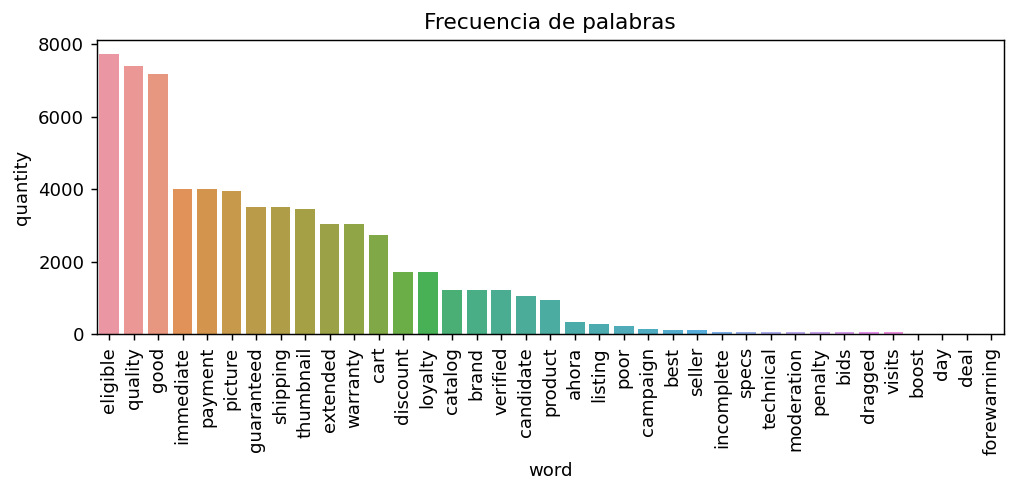

In [155]:
# Graficamos
words_cnt=words_freq(data_m.tags).head(75)
plt.figure(figsize=(9,3),dpi=130)
sns.barplot(data=words_cnt,x='word',y='quantity')
plt.title("Frecuencia de palabras")
plt.xticks(rotation=90);

In [156]:
words_cnt.head()

,word,quantity
0,eligible,7741
1,quality,7394
2,good,7178
3,immediate,3990
4,payment,3990


Como vemos las siguientes palabras son las *eligible, quality, good, immediate,	payment*

In [157]:
# token del metodo CountVectorizer
tokens=vect.get_feature_names()

In [158]:
# detecto palabras que no son reales, acorde al idioma que elegi
real_words=[]
wrong_words=[]
import enchant
from tqdm import tqdm 
spell=enchant.DictWithPWL("en_US")

for word in tqdm(tokens):
    if  spell.check(word):
        real_words.append(word)
    else:
        wrong_words.append(word)

stop_words_m = stopwords.words('english')
stop_words_m = text.ENGLISH_STOP_WORDS.union(wrong_words)

100%|█████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 506.88it/s]


In [159]:
print('Existe/n {} palabras que no son validas en ingles'.format(len(wrong_words)))
print('Existe/n {} palabras que son validas en el ingles'.format(len(real_words)))

Existe/n 1 palabras que no son validas en ingles
Existe/n 36 palabras que son validas en el ingles


In [160]:
print('La palabra que no reconoce es precisamente "{}"'.format(wrong_words[0]))

La palabra que no reconoce es precisamente "ahora"


La palabra que en los tags no corresponde debido al idioma elegido en la funcion anterior es "Ahora" que corresponde al tag: *Ahora-12*.

In [161]:
# me aseguro de no conservar datos nulos en los registros
data_m.dropna(inplace = True)

In [162]:
data_m

,price,discount,available_quantity,sold_quantity,listing_type_id,condition,domain_id,tags,state_name,city_name,power_seller_status,level_id,ranking_success,negative,positive,free_shipping,store_pick_up
0,54999.0,0.0,1,121,gold_special,new,MLA-TELEVISIONS,loyalty discount eligible brand verified ...,Capital Federal,Once,platinum,5_green,0.942664,0.02,0.96,True,False
1,49999.0,0.0,1,250,gold_special,new,MLA-TELEVISIONS,extended warranty eligible good quality p...,Buenos Aires,Villa Celina,platinum,5_green,0.953807,0.06,0.93,True,False
2,75999.0,0.0,273,7388,gold_pro,new,MLA-TELEVISIONS,ahora brand verified extended warrant...,Buenos Aires,Villa Celina,platinum,5_green,0.953807,0.06,0.93,True,False
3,10888.0,0.0,3,2,gold_special,new,MLA-STREAMING_MEDIA_DEVICES,good quality picture good quality thumbna...,Capital Federal,CABA,platinum,5_green,0.961624,0.00,0.99,True,False
4,66999.0,0.0,250,250,gold_pro,new,MLA-TELEVISIONS,ahora catalog product candidate exten...,Buenos Aires,Villa Celina,platinum,5_green,0.953807,0.06,0.93,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4154,59998.8,0.0,1,3,gold_special,new,MLA-NOTEBOOKS,extended warranty eligible good quality p...,Buenos Aires,Ranelagh,platinum,5_green,0.922966,0.03,0.96,True,False
4155,150985.0,0.0,1,5,gold_pro,new,MLA-NOTEBOOKS,brand verified extended warranty eligible...,Capital Federal,Villa Crespo,platinum,5_green,0.957775,0.01,0.97,True,False
4157,159000.0,0.0,1,5,gold_pro,new,MLA-NOTEBOOKS,good quality picture good quality thumbna...,Buenos Aires,Villa Bosch,gold,5_green,0.962629,0.03,0.97,True,False
4158,83999.0,0.0,1,50,gold_special,new,MLA-NOTEBOOKS,good quality thumbnail loyalty discount e...,Capital Federal,San Nicolás,platinum,5_green,0.963336,0.01,0.97,True,False


In [163]:
data_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3422 entries, 0 to 4159
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                3422 non-null   float64
 1   discount             3422 non-null   float64
 2   available_quantity   3422 non-null   int64  
 3   sold_quantity        3422 non-null   int64  
 4   listing_type_id      3422 non-null   object 
 5   condition            3422 non-null   object 
 6   domain_id            3422 non-null   object 
 7   tags                 3422 non-null   object 
 8   state_name           3422 non-null   object 
 9   city_name            3422 non-null   object 
 10  power_seller_status  3422 non-null   object 
 11  level_id             3422 non-null   object 
 12  ranking_success      3422 non-null   float64
 13  negative             3422 non-null   float64
 14  positive             3422 non-null   float64
 15  free_shipping        3422 non-null   b

---
<a href="#top">Back to Index</a>
<a id="2"></a>
### 2) Preproceso de datos
<a id="2.1"></a>
#### 2.1) Preparacion de los datos

El data set obtenido de los *results* de la consulta existen ciertos campos que se han seleecionado para el analisis siendo *sold_quantity* la variable target.
Debido a que tenemos varios tipos de datos voy a proceder a realizar ciertos cambios

In [164]:
data_m['free_shipping']=data_m['free_shipping'].astype('category')
data_m['store_pick_up']=data_m['store_pick_up'].astype('category')

In [165]:
data_m['free_shipping']=data_m['free_shipping'].apply(lambda x: 1 if x == 'True' else 0)
data_m['store_pick_up']=data_m['store_pick_up'].apply(lambda x: 1 if x == 'True' else 0)

Voy a identificar los tipos de datos que tengo en *numericos* y *categoricos*

In [212]:
# armo las listas de variables categorias y numericas
num_features = [x for x in X.select_dtypes(include=['number']).columns]
cat_features = [x for x in X.columns if x not in num_features]
print('Variables categoricas: %s' %cat_features)
print('--------------------------------------------------')
print('Variables numericas: %s' %num_features)

Variables categoricas: ['listing_type_id', 'condition', 'domain_id', 'tags', 'state_name', 'city_name', 'power_seller_status', 'level_id']
--------------------------------------------------
Variables numericas: ['price', 'discount', 'available_quantity', 'ranking_success', 'negative', 'positive', 'free_shipping', 'store_pick_up']


In [214]:
# vamos a tener un tratamiento especial para tag
cat_features.remove('tags')
print('Variables categoricas: %s' %cat_features)

Variables categoricas: ['listing_type_id', 'condition', 'domain_id', 'state_name', 'city_name', 'power_seller_status', 'level_id']


<a id="2.2"></a>
#### 2.2) Separación de datos en Train y Test

In [215]:
X=data_m[[x for x in data_m.columns if x !='sold_quantity']]
y=data_m['sold_quantity']

# split usando una relación de 80% de datos para train, y 20% datos para test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

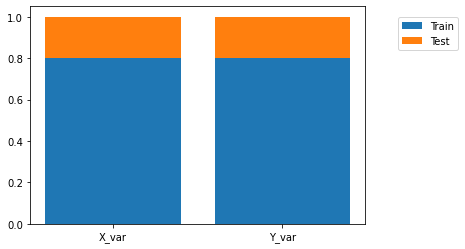

In [216]:
xplot = ['X_var','Y_var']
trainplot = [X_train.shape[0]/X.shape[0],y_train.shape[0]/y.shape[0]]
testplot = [X_test.shape[0]/X.shape[0],y_test.shape[0]/y.shape[0]]
fig, ax = plt.subplots()
ax.bar(xplot,trainplot,label = 'Train')
ax.bar(xplot,testplot,bottom = trainplot,label = 'Test')
ax.legend(loc = (1.1,0.8))

In [217]:
X_train.head()

,price,discount,available_quantity,listing_type_id,condition,domain_id,tags,state_name,city_name,power_seller_status,level_id,ranking_success,negative,positive,free_shipping,store_pick_up
2293,34999.0,0.000000,1,gold_special,new,MLA-TABLETS,good quality picture good quality thumbna...,Capital Federal,Balvanera,platinum,5_green,0.973946,0.00,1.00,0,0
3542,65694.0,0.000000,1,gold_pro,new,MLA-NOTEBOOKS,good quality picture good quality thumbna...,Santa Fe,Rosario,platinum,5_green,0.971469,0.03,0.96,0,0
862,108799.0,0.000000,1,gold_special,new,MLA-TELEVISIONS,extended warranty eligible good quality p...,Buenos Aires,La Plata,platinum,5_green,0.928036,0.03,0.92,0,0
2520,9395.0,0.000000,1,gold_special,new,MLA-TABLETS,extended warranty eligible good quality p...,Córdoba,Córdoba,platinum,5_green,0.946444,0.03,0.94,0,0
2632,9899.0,0.090909,1,gold_special,new,MLA-TABLETS,extended warranty eligible good quality p...,Córdoba,Córdoba,platinum,5_green,0.945735,0.01,0.96,0,0


In [218]:
X_train.shape

(2737, 16)

<a id="2.3"></a>
#### 2.4) Vectorizamos con Tf_idf

In [219]:
# stop_words=stop_words_m  no voy a sacar el ahora 12
vectorizer=TfidfVectorizer(lowercase=True,strip_accents='unicode',max_df=0.7)
vectorizer.fit(X_train['tags'])

TfidfVectorizer(max_df=0.7, strip_accents='unicode')

In [220]:
X_train_tags = pd.DataFrame(vectorizer.transform(X_train['tags']).todense() )
X_test_tags = pd.DataFrame(vectorizer.transform(X_test['tags']).todense() )

In [221]:
# tengo que dropear 'tags' y resetear los indices
X_train.drop(['tags'],axis =1, inplace = True)
X_test.drop(['tags'],axis =1, inplace = True)

X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)

In [254]:
# tambien lo aplico  a y
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

<a id="2.4"></a>
#### 2.4 Encoding de variables categóricas
Vamos a tratar las variables categoricas usando la libreria de *OneHotEncoder*

In [225]:
# con OneHotEncoder creamos variables dummies para place_name
onehot_encoder = OneHotEncoder(sparse=False,handle_unknown='ignore')

#X train enconded
X_ohe_train = onehot_encoder.fit_transform(X_train[cat_features])
X_ohe_train = pd.DataFrame(X_ohe_train, columns = onehot_encoder.get_feature_names(cat_features))

#X test enconded
X_ohe_test = onehot_encoder.transform(X_test[cat_features])
X_ohe_test = pd.DataFrame(X_ohe_test, columns = onehot_encoder.get_feature_names(cat_features))

<a id="2.5"></a>
#### 2.5 Standarización de variables numéricas
Vamos a tratar las variables numericas, usando *MinMaxScaler* para hacer la normalizacion

In [227]:
# normalization of X_train
min_max_scaler = preprocessing.MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train[num_features])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_features)


# normalization of X_test
X_test_scaled = min_max_scaler.transform(X_test[num_features])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_features)

<a id="2.6"></a>
#### 2.6 Features de Train y Test

Finalmente vamos unificar lo trabajado hasta el momento para crear los set de train y test para el modelo

In [232]:
print('Sizes de los distintos datasets de entrenamiento y testeo')
print('Train Tags Vectorizado: ',X_train_tags.shape)
print('Train Tags Vectorizado: ', X_test_tags.shape)
print('--------------------------------------------------')
print('Train OHE: ' ,X_ohe_train.shape)
print('Test OHE: ', X_ohe_test.shape)
print('--------------------------------------------------')
print('Train Scaled: ',X_train_scaled.shape)
print('Test Scaled: ', X_test_scaled.shape)

Sizes de los distintos datasets de entrenamiento y testeo
Train Tags Vectorizado:  (2737, 28)
Train Tags Vectorizado:  (685, 28)
--------------------------------------------------
Train OHE:  (2737, 206)
Test OHE:  (685, 206)
--------------------------------------------------
Train Scaled:  (2737, 8)
Test Scaled:  (685, 8)


In [236]:
# concatenamos los datasets obtenidos hasta el momento
X_train = pd.concat([X_train_scaled, X_ohe_train , X_train_tags], axis = 1)
X_test = pd.concat([X_test_scaled, X_ohe_test, X_test_tags], axis = 1)

In [237]:
# luego de la unificacion
display(X_train.shape)
display(X_test.shape)

(2737, 242)

(685, 242)

In [247]:
display(y_train.shape)
display(y_test.shape)

(2737,)

(685,)

---
<a href="#top">Back to Index</a>
<a id="3"></a>
### 3) Modelos de Predicción


<a id="3.1"></a>
#### 3.1) Stats Model

<a id="3.1.1"></a>
##### 3.1.1) Regresión Lineal

Vamos a usar realizar una regresión lineal con Stats Model para poder analizar como se comportan las features del modelo.

In [256]:
# agregamos la columna para intercept
import statsmodels.api as sm  
X_train = sm.add_constant(X_train)

In [257]:
#fiteo el modelo
osl_m = sm.OLS(y_train,X_train,missing='drop').fit()

In [259]:
print(osl_m.summary())

                            OLS Regression Results                            
Dep. Variable:          sold_quantity   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     3.422
Date:                Fri, 13 Aug 2021   Prob (F-statistic):           2.79e-47
Time:                        15:18:50   Log-Likelihood:                -20013.
No. Observations:                2737   AIC:                         4.044e+04
Df Residuals:                    2528   BIC:                         4.168e+04
Df Model:                         208                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [262]:
#Creo lista con las columnas eliminadas
feature_removed=[]
def p_value(X_train,y_train,alpha):
    
    feature_over_alpha_limit=1
        
    while feature_over_alpha_limit>0:
       
        #creo DF que contenga los features que Quedan en el modelo
        df=pd.DataFrame(columns=['Feature','P_Value'])
        feature_names=X_train.columns

        #fiteo el modelo
        osl_m = sm.OLS(y_train,X_train).fit()

        #Genero DF con P Values
        for i in range (0, X_train.shape[1]):
            p_values=(osl_m.pvalues[i]).round(3)
            df.loc[i]=[feature_names[i],p_values]

        #obtengo el maximo P_value del modelo
        Max_feature=df['P_Value'].idxmax()
        Max_P_value=df['P_Value'].max()

        #obtengo el feature a eliminar del modelo
        feature_to_exclude=df.loc[[Max_feature],['Feature']].iat[0,0]
        feature_removed.append(feature_to_exclude)

        #Elimino el feature del modelo
        X_train.drop(feature_to_exclude,axis=1,inplace=True)

        #obtener lista con cantidad de features con P value > 0.05
        feature_over_alpha_limit=len([x for x in df['P_Value'] if float(x) >=alpha])

    print("La cantidad de Features removidos es: ",feature_removed,"\nEl R2 es: ",osl_m.rsquared_adj.round(3))

Aplicamos la función **p_value** para remover aquellos features en donde su p_value es mayor a 0.05

In [265]:
# tengo un error con la key 28 ## a resolver
p_value(X_train,y_train,0.05)

In [264]:
#feature_removed

[]

<a id="3.1.2"></a>
##### 3.1.2) Regresión Lineal con Feature Selection

In [266]:
#fiteo el modelo
osl_m = sm.OLS(y_train,X_train).fit()
print(osl_m.summary())

                            OLS Regression Results                            
Dep. Variable:          sold_quantity   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     3.422
Date:                Fri, 13 Aug 2021   Prob (F-statistic):           2.79e-47
Time:                        15:25:23   Log-Likelihood:                -20013.
No. Observations:                2737   AIC:                         4.044e+04
Df Residuals:                    2528   BIC:                         4.168e+04
Df Model:                         208                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [267]:
#Eliminamos los features que eliminamos en el training
X_test.drop(feature_removed,axis=1,inplace=True)

In [268]:
#agregamos la constante del modelo OLS
X_test = sm.add_constant(X_test)

In [269]:
#Fiteamos el modelo 
y_pred=osl_m.predict(X_test)

In [272]:
# Evaluamos el R2 usando Sklearn
r2_score(y_test, y_pred)

0.3135350833805619

<a id="3.1.3"></a>
##### 3.1.3) VIF (Variance Inflation Factor)

In [273]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif.sort_values(by='VIF',ascending=False)
    return(vif)

In [274]:
calc_vif(X_train)

,variables,VIF
0,price,3.016652
1,discount,1.494609
2,available_quantity,3.003503
3,ranking_success,3.204932
4,negative,3.437606
...,...,...
237,23,inf
238,24,inf
239,25,inf
240,26,inf


<a id="3.1.4"></a>
##### 3.1.4) RFE (Feature Ranking with recursive elimination)

Documentación: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

In [276]:
#X_train.drop('const',axis=1,inplace=True)
#X_test.drop('const',axis=1,inplace=True)

In [282]:
# instanciamos y entrenamos el modelo
kf = KFold(n_splits=5, shuffle = True)
estimator = RandomForestRegressor()
selector = RFECV(estimator, step = 1, cv=kf, scoring = 'r2', verbose=2)
selector.fit(X_train, y_train)

Fitting estimator with 242 features.
Fitting estimator with 241 features.
Fitting estimator with 240 features.
Fitting estimator with 239 features.
Fitting estimator with 238 features.
Fitting estimator with 237 features.
Fitting estimator with 236 features.
Fitting estimator with 235 features.
Fitting estimator with 234 features.
Fitting estimator with 233 features.
Fitting estimator with 232 features.
Fitting estimator with 231 features.
Fitting estimator with 230 features.
Fitting estimator with 229 features.
Fitting estimator with 228 features.
Fitting estimator with 227 features.
Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
F

Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 242 features.
Fitting estimator with 241 features.
Fitting estimator with 240 features.
Fitting estimator with 239 features.
Fitting estimator with 238 features.
Fitting estimator with 237 features.
Fitting estimator with 236 features.
Fitting estimator with 235 features.
Fitting estimator with 234 features.
Fitting estimator with 233 features.
Fitting estimator with 232

Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 feat

Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 fe

Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 fe

Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 fe

Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 7

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
      estimator=RandomForestRegressor(), scoring='r2', verbose=2)

In [283]:
selector

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
      estimator=RandomForestRegressor(), scoring='r2', verbose=2)

In [284]:
X_train.loc[:,selector.support_].columns

Index([                                            'price',
                                                'discount',
                                      'available_quantity',
                                         'ranking_success',
                                                'negative',
                                                'positive',
                                'listing_type_id_gold_pro',
                            'listing_type_id_gold_special',
       'domain_id_MLA-AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS',
                                'domain_id_MLA-CELLPHONES',
                                 'domain_id_MLA-NOTEBOOKS',
                   'domain_id_MLA-STREAMING_MEDIA_DEVICES',
                                   'domain_id_MLA-TABLETS',
                               'domain_id_MLA-TELEVISIONS',
                        'domain_id_MLA-TV_REMOTE_CONTROLS',
                                 'state_name_Buenos Aires',
                              'state_nam

In [285]:
scores = pd.DataFrame()
scores['Attribute Name'] = X_train.columns
scores['Ranking'] = selector.ranking_
scores['Support'] = selector.support_

display(scores.sort_values(by='Ranking',ascending=True))

,Attribute Name,Ranking,Support
0,price,1,True
170,city_name_San Nicolás,1,True
161,city_name_San Cristóbal,1,True
156,city_name_Rosario,1,True
142,city_name_Posadas,1,True
...,...,...,...
175,city_name_Santo Tomé,171,False
148,city_name_Quilmes Oeste,172,False
100,city_name_Laferrere,173,False
26,state_name_La Pampa,174,False


In [287]:
scores[scores['Ranking']==1].sort_values(by='Ranking',ascending=True)

,Attribute Name,Ranking,Support
0,price,1,True
138,city_name_Parque Patricios,1,True
139,city_name_Pergamino,1,True
142,city_name_Posadas,1,True
156,city_name_Rosario,1,True
...,...,...,...
47,city_name_Balvanera,1,True
45,city_name_Bahía Blanca,1,True
39,city_name_Almagro,1,True
57,city_name_Buenos Aires,1,True


<a id="3.2"></a>
#### 3.2) CatBoost

CatBoost Tuneado

In [310]:
# Función para evaluar el rendimiento del modelo con los datos de Train
def evaluar_rendimiento(modelo, nombre, X, y, cv, scoring='r2'):
    s = cross_val_score(modelo, X, y, cv=cv, n_jobs=-1, scoring=scoring)
    print("Rendimiento de {}:\t{:0.3} ± {:0.3}".format( \
        nombre, s.mean().round(3), s.std().round(3)))
    return s.mean()

In [311]:
# DataFrame para guardar el desempeño de los modelos
model_comparison = pd.DataFrame(columns = {'Model'})
# model_comparison

In [312]:
# Instanciamos Cross Validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)

In [313]:
# Instanciamos el modelo que vamos a entrenar
model_cbr = CatBoostRegressor()
model_comparison.loc[1,'Model'] = 'CatBoostRegressor'

In [314]:
# Creamos la grilla de parametros
params = {  
      
    "depth": [5,6,7,8,9],            
    "learning_rate": [0.001, 0.01, 0.1],      
}

In [315]:
# Creamos la grilla con GridSearch
cbr = GridSearchCV(model_cbr, param_grid=params, cv=cv, verbose=1, n_jobs=-1)

In [316]:
# Entrenamos el modelo
cbr.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  7.1min finished


0:	learn: 410.1324241	total: 37ms	remaining: 37s
1:	learn: 409.9364829	total: 47ms	remaining: 23.5s
2:	learn: 409.7371553	total: 57.1ms	remaining: 19s
3:	learn: 409.5341622	total: 67ms	remaining: 16.7s
4:	learn: 409.3403300	total: 77.1ms	remaining: 15.3s
5:	learn: 409.1447210	total: 87.9ms	remaining: 14.6s
6:	learn: 408.9493011	total: 97.9ms	remaining: 13.9s
7:	learn: 408.7570578	total: 108ms	remaining: 13.4s
8:	learn: 408.5627142	total: 118ms	remaining: 13s
9:	learn: 408.3714313	total: 128ms	remaining: 12.7s
10:	learn: 408.2256312	total: 139ms	remaining: 12.5s
11:	learn: 408.0308519	total: 152ms	remaining: 12.5s
12:	learn: 407.8319697	total: 157ms	remaining: 11.9s
13:	learn: 407.6381507	total: 171ms	remaining: 12.1s
14:	learn: 407.4915603	total: 184ms	remaining: 12.1s
15:	learn: 407.2895640	total: 194ms	remaining: 11.9s
16:	learn: 407.0934508	total: 205ms	remaining: 11.8s
17:	learn: 406.9507848	total: 216ms	remaining: 11.8s
18:	learn: 406.7565135	total: 227ms	remaining: 11.7s
19:	lear

158:	learn: 382.3223355	total: 1.64s	remaining: 8.66s
159:	learn: 382.1364357	total: 1.65s	remaining: 8.65s
160:	learn: 382.0013924	total: 1.66s	remaining: 8.66s
161:	learn: 381.8679506	total: 1.67s	remaining: 8.65s
162:	learn: 381.6893445	total: 1.68s	remaining: 8.64s
163:	learn: 381.5568175	total: 1.7s	remaining: 8.64s
164:	learn: 381.4236718	total: 1.71s	remaining: 8.63s
165:	learn: 381.2393434	total: 1.72s	remaining: 8.62s
166:	learn: 381.0564509	total: 1.73s	remaining: 8.62s
167:	learn: 380.8789661	total: 1.74s	remaining: 8.6s
168:	learn: 380.6943112	total: 1.75s	remaining: 8.59s
169:	learn: 380.5174039	total: 1.76s	remaining: 8.58s
170:	learn: 380.3435930	total: 1.77s	remaining: 8.57s
171:	learn: 380.1654164	total: 1.78s	remaining: 8.55s
172:	learn: 379.9885500	total: 1.79s	remaining: 8.54s
173:	learn: 379.8148711	total: 1.8s	remaining: 8.53s
174:	learn: 379.6842378	total: 1.81s	remaining: 8.53s
175:	learn: 379.5083540	total: 1.82s	remaining: 8.53s
176:	learn: 379.3338258	total: 

312:	learn: 357.8799784	total: 3.2s	remaining: 7.01s
313:	learn: 357.7161239	total: 3.21s	remaining: 7s
314:	learn: 357.5536848	total: 3.22s	remaining: 7s
315:	learn: 357.3936383	total: 3.23s	remaining: 6.99s
316:	learn: 357.2256038	total: 3.24s	remaining: 6.97s
317:	learn: 357.1041294	total: 3.25s	remaining: 6.96s
318:	learn: 356.9774631	total: 3.26s	remaining: 6.95s
319:	learn: 356.8163235	total: 3.27s	remaining: 6.94s
320:	learn: 356.6544296	total: 3.28s	remaining: 6.93s
321:	learn: 356.4871017	total: 3.29s	remaining: 6.92s
322:	learn: 356.3306921	total: 3.3s	remaining: 6.91s
323:	learn: 356.2097381	total: 3.31s	remaining: 6.9s
324:	learn: 356.0408215	total: 3.31s	remaining: 6.88s
325:	learn: 355.8797839	total: 3.33s	remaining: 6.87s
326:	learn: 355.7530042	total: 3.33s	remaining: 6.86s
327:	learn: 355.5860941	total: 3.34s	remaining: 6.85s
328:	learn: 355.4667571	total: 3.35s	remaining: 6.84s
329:	learn: 355.2989051	total: 3.36s	remaining: 6.83s
330:	learn: 355.1366480	total: 3.37s	

474:	learn: 334.7619673	total: 4.78s	remaining: 5.29s
475:	learn: 334.6180085	total: 4.79s	remaining: 5.28s
476:	learn: 334.4726204	total: 4.8s	remaining: 5.27s
477:	learn: 334.3204866	total: 4.81s	remaining: 5.26s
478:	learn: 334.1999227	total: 4.83s	remaining: 5.25s
479:	learn: 334.0474883	total: 4.83s	remaining: 5.24s
480:	learn: 333.9007058	total: 4.84s	remaining: 5.23s
481:	learn: 333.7538801	total: 4.86s	remaining: 5.22s
482:	learn: 333.6427176	total: 4.87s	remaining: 5.21s
483:	learn: 333.4934758	total: 4.87s	remaining: 5.2s
484:	learn: 333.3752960	total: 4.88s	remaining: 5.19s
485:	learn: 333.2295048	total: 4.89s	remaining: 5.18s
486:	learn: 333.0792830	total: 4.9s	remaining: 5.17s
487:	learn: 332.9264200	total: 4.91s	remaining: 5.16s
488:	learn: 332.7737044	total: 4.92s	remaining: 5.14s
489:	learn: 332.6571488	total: 4.93s	remaining: 5.13s
490:	learn: 332.5136936	total: 4.94s	remaining: 5.13s
491:	learn: 332.4065406	total: 4.95s	remaining: 5.11s
492:	learn: 332.2908625	total: 

638:	learn: 313.3916929	total: 6.39s	remaining: 3.61s
639:	learn: 313.2590512	total: 6.4s	remaining: 3.6s
640:	learn: 313.1602583	total: 6.41s	remaining: 3.59s
641:	learn: 313.0251904	total: 6.42s	remaining: 3.58s
642:	learn: 312.9119080	total: 6.43s	remaining: 3.57s
643:	learn: 312.8084694	total: 6.44s	remaining: 3.56s
644:	learn: 312.6704681	total: 6.45s	remaining: 3.55s
645:	learn: 312.5418128	total: 6.46s	remaining: 3.54s
646:	learn: 312.4061868	total: 6.47s	remaining: 3.53s
647:	learn: 312.2752868	total: 6.48s	remaining: 3.52s
648:	learn: 312.1374693	total: 6.49s	remaining: 3.51s
649:	learn: 312.0336740	total: 6.5s	remaining: 3.5s
650:	learn: 311.8951348	total: 6.51s	remaining: 3.49s
651:	learn: 311.7626136	total: 6.52s	remaining: 3.48s
652:	learn: 311.6599243	total: 6.53s	remaining: 3.47s
653:	learn: 311.5237233	total: 6.54s	remaining: 3.46s
654:	learn: 311.4431021	total: 6.55s	remaining: 3.45s
655:	learn: 311.3444870	total: 6.56s	remaining: 3.44s
656:	learn: 311.2072245	total: 6

796:	learn: 295.2154737	total: 7.97s	remaining: 2.03s
797:	learn: 295.0855297	total: 7.98s	remaining: 2.02s
798:	learn: 294.9604622	total: 7.99s	remaining: 2.01s
799:	learn: 294.8369168	total: 8s	remaining: 2s
800:	learn: 294.7066267	total: 8.01s	remaining: 1.99s
801:	learn: 294.6145132	total: 8.02s	remaining: 1.98s
802:	learn: 294.5238521	total: 8.03s	remaining: 1.97s
803:	learn: 294.4316903	total: 8.04s	remaining: 1.96s
804:	learn: 294.3119675	total: 8.05s	remaining: 1.95s
805:	learn: 294.2179276	total: 8.06s	remaining: 1.94s
806:	learn: 294.0920623	total: 8.07s	remaining: 1.93s
807:	learn: 293.9972677	total: 8.08s	remaining: 1.92s
808:	learn: 293.8761842	total: 8.09s	remaining: 1.91s
809:	learn: 293.7517390	total: 8.1s	remaining: 1.9s
810:	learn: 293.6307280	total: 8.11s	remaining: 1.89s
811:	learn: 293.5401087	total: 8.12s	remaining: 1.88s
812:	learn: 293.4143608	total: 8.13s	remaining: 1.87s
813:	learn: 293.2954160	total: 8.14s	remaining: 1.86s
814:	learn: 293.1742859	total: 8.15s

958:	learn: 278.6033713	total: 9.58s	remaining: 409ms
959:	learn: 278.4968191	total: 9.59s	remaining: 399ms
960:	learn: 278.3999534	total: 9.6s	remaining: 390ms
961:	learn: 278.2897851	total: 9.61s	remaining: 380ms
962:	learn: 278.1809192	total: 9.62s	remaining: 370ms
963:	learn: 278.0942159	total: 9.63s	remaining: 360ms
964:	learn: 278.0022821	total: 9.64s	remaining: 350ms
965:	learn: 277.8982518	total: 9.65s	remaining: 340ms
966:	learn: 277.8099903	total: 9.66s	remaining: 330ms
967:	learn: 277.6927367	total: 9.67s	remaining: 320ms
968:	learn: 277.6049469	total: 9.68s	remaining: 310ms
969:	learn: 277.4970705	total: 9.69s	remaining: 300ms
970:	learn: 277.3778737	total: 9.7s	remaining: 290ms
971:	learn: 277.2939892	total: 9.71s	remaining: 280ms
972:	learn: 277.2067697	total: 9.72s	remaining: 270ms
973:	learn: 277.1001682	total: 9.73s	remaining: 260ms
974:	learn: 276.9870877	total: 9.74s	remaining: 250ms
975:	learn: 276.8799041	total: 9.75s	remaining: 240ms
976:	learn: 276.7886451	total:

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x000001E27E95CE50>,
             n_jobs=-1,
             param_grid={'depth': [5, 6, 7, 8, 9],
                         'learning_rate': [0.001, 0.01, 0.1]},
             verbose=1)

In [317]:
# Mejores parametros 
print('Best parameters:  ',cbr.best_params_)

# Evaluamos el rendimiento del modelo
model_comparison.loc[1,'Train_score'] = evaluar_rendimiento(cbr.best_estimator_,"CatBoost", X_train, y_train, cv)

# Calculamos las predicciones
y_pred_cbr = cbr.predict(X_test)

#Rendimiento del modelo con los datos de test
r2 = r2_score(y_test,y_pred_cbr)
print('r² es igual a: ', r2)
model_comparison.loc[1,'Test_score'] = r2

# Ploteamos las features importantes
#from xgboost import plot_importance
#plot_importance(xgb.best_estimator_, height = 0.8,max_num_features=15)

Best parameters:   {'depth': 9, 'learning_rate': 0.001}
Rendimiento de CatBoost:	0.235 ± 0.302
r² es igual a:  0.32044943488806266


<AxesSubplot:>

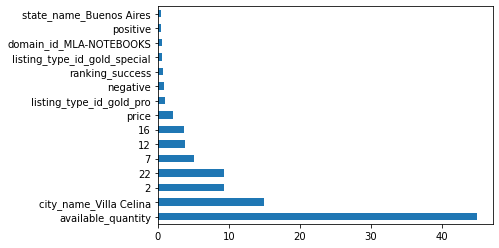

In [318]:
feat_importances = pd.Series(cbr.best_estimator_.get_feature_importance(), index=X_test.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [319]:
model_comparison

,Model,Train_score,Test_score
1,CatBoostRegressor,0.234517,0.320449


<a href="#top">Back to Index</a>
<a id="4"></a>
### 4) Conclusion de Parte II

En esta instancia se trato de realizar un modelo para poder predecir las unidades vendidas *sold_quantity* de una publicacion.
Si bien los valores obtenidos son bajos, hay que tomar en cuenta la informacion del data set.
Existen muchos datos referidos al vendedor, y los elementos de tag son muy genericos no necesariamente de la publicacion, posiblemente con datos especificos de las publicaciones utilizando otro recurso de la API de MELI se pueden obtener datos referentes al producto del campo ***atributes: {}*** mediante la ***id*** de cada publicacion.

Tambien mas que hacerlo generico, crearia un modelo para cada uno de las distintas categorias del modelo,
ya sea televisores, celulares, etc. y repetir el entrenamiento, muy posiblemente algunas variables sean comunes.

Queda pendiente, al momento de usar Vectorizamos con ***TfidfVectorizer***, identificar el nombre de las variables de la matriz exparsa con las palabras de ***tags*** para poder ver con el feature importance 



In [ ]:
#df_part1.to_excel('./data/data_part1.xlsx', index= False)
#df_part1.to_csv('./data/data_part1.csv', index= False)

In [320]:
#pip freeze > requirements.txt